In [1]:
import os

import torch
import numpy as np
import pandas as pd
import seaborn as sns
from random import sample
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
summit_name = '10th_summit_add_columns_epochs_300'

In [3]:
train_data = pd.read_csv('data/train.csv', index_col='id')
test_data = pd.read_csv('data/test.csv', index_col='id')
train_data

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,NumDealsPurchases,NumWebPurchases,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,target
id,,,,,,,,,,,,,,,,,,,,,
0,1974,Master,Together,46014.0,1,1,21-01-2013,21,10,7,...,8,7,0,0,0,0,0,0,0,541
1,1962,Graduation,Single,76624.0,0,1,24-05-2014,68,1,5,...,7,1,1,0,0,0,0,0,0,899
2,1951,Graduation,Married,75903.0,0,1,08-04-2013,50,2,6,...,9,3,0,0,0,0,0,0,0,901
3,1974,Basic,Married,18393.0,1,0,29-03-2014,2,2,3,...,3,8,0,0,0,0,0,0,0,50
4,1946,PhD,Together,64014.0,2,1,10-06-2014,56,7,8,...,5,7,0,0,0,1,0,0,0,444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1103,1956,Graduation,Together,46097.0,0,1,31-03-2013,11,5,3,...,6,4,0,0,0,0,0,0,0,241
1104,1986,Graduation,Married,23477.0,1,0,21-10-2013,39,3,3,...,4,8,0,0,0,0,0,0,0,147
1105,1975,Master,Married,37368.0,1,0,16-12-2013,4,1,1,...,2,6,1,0,0,0,0,0,0,30


In [4]:
def seperate_datetime(dataframe):
    year = []
    month = []
    day = []

    for date in dataframe.Dt_Customer:
        year_point, month_point, day_point = date.split('-') # - 기준으로 string을 나누고 list로 만듦 ex) '2016-04-01' -> ['2016', '04', '01']
        year.append(int(year_point))
        month.append(int(month_point))
        day.append(int(day_point))
    return year, month, day

day, month, year = seperate_datetime(train_data)
    
train_data['year'] = year
train_data['month'] = month
train_data['day'] = day

_, _, test_year = seperate_datetime(test_data)
test_data['year'] = test_year

/tmp/ipykernel_534/1904963444.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_corr[train_corr.columns] = scaler.fit_transform(train_corr[train_corr.columns])


Text(0.5, 1.0, 'Correlation between features')

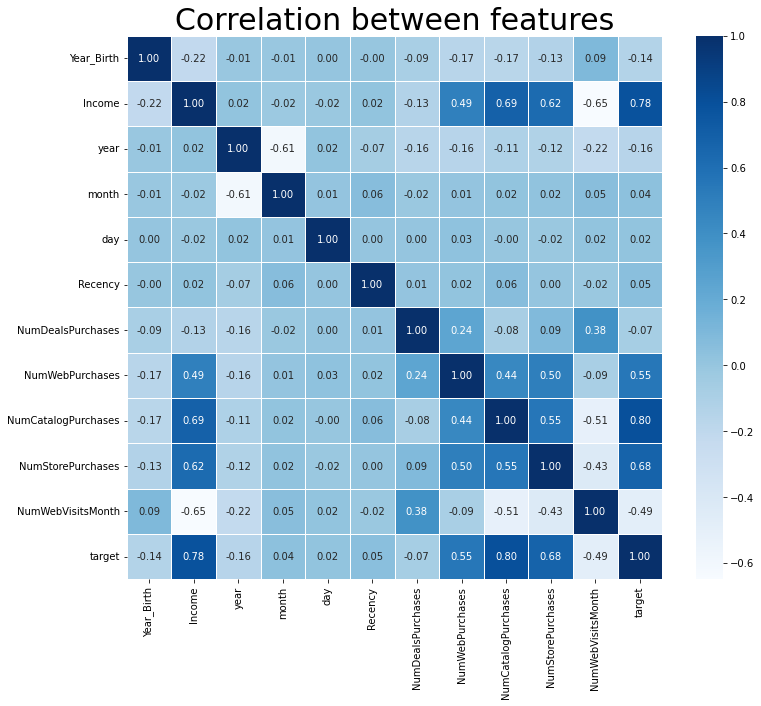

In [5]:
quantitative = ['Year_Birth', 'Income', 'year',	'month', 'day', 'Recency', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']
quantitative.append('target')

train_corr = train_data[quantitative]
scaler= MinMaxScaler() 
train_corr[train_corr.columns] = scaler.fit_transform(train_corr[train_corr.columns])
corr28 = train_corr.corr(method= 'pearson')

plt.figure(figsize=(12,10))
sns.heatmap(data = corr28, annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')
plt.title('Correlation between features', fontsize=30)

In [6]:
s28 = corr28.unstack()
df_temp28 = pd.DataFrame(s28['target'].sort_values(ascending=False), columns=['target'])
df_temp28.style.background_gradient(cmap='viridis')

,target
target,1.000000
NumCatalogPurchases,0.798065
Income,0.784084
NumStorePurchases,0.677785
NumWebPurchases,0.546082
Recency,0.050873
month,0.037649
day,0.018917
NumDealsPurchases,-0.072802
Year_Birth,-0.136035


In [7]:
filtered_train_data = train_data[['NumCatalogPurchases','Income','NumStorePurchases','NumWebPurchases', 'NumWebVisitsMonth','year', 'target']].to_numpy()
filtered_test_data = test_data[['NumCatalogPurchases','Income','NumStorePurchases','NumWebPurchases','NumWebVisitsMonth','year']].to_numpy()

In [8]:
scaler= MinMaxScaler()
train_x = scaler.fit_transform(filtered_train_data[:,:-1])
train_y = filtered_train_data[:,-1]
target_x = scaler.transform(filtered_test_data) 

In [9]:
print('tarin_x:')
print(train_x)
print('target_x:')
print(target_x)

tarin_x:
[[0.09090909 0.27562598 0.61538462 0.25925926 0.35       0.5       ]
 [0.90909091 0.46614426 0.53846154 0.18518519 0.05       1.        ]
 [0.54545455 0.46165672 0.69230769 0.22222222 0.15       0.5       ]
 ...
 [0.         0.22181282 0.15384615 0.03703704 0.3        0.5       ]
 [0.09090909 0.31931884 0.53846154 0.22222222 0.4        0.5       ]
 [0.09090909 0.27933552 0.46153846 0.14814815 0.3        0.        ]]
target_x:
[[0.27272727 0.34734575 0.61538462 0.14814815 0.2        0.5       ]
 [0.36363636 0.39845146 0.76923077 0.07407407 0.05       0.5       ]
 [0.27272727 0.33425657 1.         0.18518519 0.2        0.5       ]
 ...
 [0.09090909 0.20082531 0.23076923 0.03703704 0.2        0.5       ]
 [0.45454545 0.45512769 0.38461538 0.07407407 0.25       0.5       ]
 [0.18181818 0.2761488  0.15384615 0.11111111 0.4        0.        ]]


In [10]:
shuffle_idx = sample(range(0, len(train_x)), len(train_x))

shuffled_train_x = np.full((len(train_x),6),[0,0,0,0,0,0],dtype=np.float64)
shuffled_train_y = np.zeros(len(train_y),dtype=np.float64)

for i in range(len(train_x)):
    shuffled_train_x[i] = train_x[shuffle_idx[i]]
    shuffled_train_y[i] = train_y[shuffle_idx[i]]

In [11]:
valid_idx = int(len(train_x) // 1.22)
test_idx = int(len(train_x) // 1.1)

In [12]:
x_train = shuffled_train_x[:valid_idx]
y_train = shuffled_train_y[:valid_idx]
x_val = shuffled_train_x[valid_idx:test_idx]
y_val = shuffled_train_y[valid_idx:test_idx]
x_test = shuffled_train_x[test_idx:]
y_test = shuffled_train_y[test_idx:]

print(f'x_train: {x_train.shape}')
print(f'x_val: {x_val.shape}')
print(f'x_test: {x_test.shape}')

x_train: (908, 6)
x_val: (99, 6)
x_test: (101, 6)


In [13]:
train_dataset = TensorDataset(torch.FloatTensor(x_train), torch.FloatTensor(y_train))
valid_dataset = TensorDataset(torch.FloatTensor(x_val), torch.FloatTensor(y_val))
test_dataset = TensorDataset(torch.FloatTensor(x_test), torch.FloatTensor(y_test))

batch_size = 1

train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_data_loader = DataLoader(valid_dataset, batch_size=1, shuffle=True, pin_memory=True)
test_data_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, pin_memory=True)

In [14]:
class Regression_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(6, 64),
            # nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64,32),
            # nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32,16),
            # nn.BatchNorm1d(8),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(16,1),
            # nn.ReLU(),
            # nn.Dropout(0.2),
            # nn.Linear(16,1),
        )
        
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [15]:
model = Regression_model()
loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,
#                                               lr_lambda=lambda epoch: 0.99 ** epoch,
#                                               last_epoch=-1,
#                                               verbose=False)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0)

In [16]:
def train_val_loop(model, loss_fn, optimizer, train_loader, valid_loader, current_epoch, test=False):
    if not test:
        train_loss = 0
        train_size = len(train_loader.dataset)
        model.train()
        for batch, (X, y) in enumerate(train_loader):
            # X, y = X.to('cuda'), y.to('cuda')
            pred = model(X)
            loss = loss_fn(pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # if batch % 100 == 0:
            #     loss, current = loss.item(), batch * len(X)
            #     print(f'loss: {loss:>7f}  [{current:>5d}/{train_size:>5d}]')
        
        train_loss /= train_size / batch_size
        if current_epoch % 10 == 0:
            print(f'Avg Train Loss: {train_loss:>8f}')

    val_size = len(valid_loader.dataset)
    num_batches = len(valid_loader)
    val_loss = 0
    model.eval()
    with torch.no_grad():
        for X, y in valid_loader:
            # X, y = X.to('cuda'), y.to('cuda')
            pred = model(X)
            val_loss += loss_fn(pred, y).item()
    
    val_loss /= num_batches
    if not test:
        if current_epoch % 10 == 0:
            print(f'Val Loss: {val_loss:>8f}\n')
            
    if not test:
        return train_loss, val_loss
    else:
        return val_loss

In [17]:
history = {'train_loss' : [], 'val_loss' : []}

epochs = 300
for t in tqdm(range(epochs)):
    if (t+1) % 10 == 0:
        print(f'Epochs {t+1}\n-------------------------------------')
    t, v = train_val_loop(model, loss_fn, optimizer, train_data_loader, val_data_loader, t+1)
    scheduler.step()
    history['train_loss'].append(t)
    history['val_loss'].append(v)
print('Training Done!')

  0%|          | 0/300 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epochs 10
-------------------------------------
Avg Train Loss: 393.732109
Val Loss: 396.217863

Epochs 20
-------------------------------------
Avg Train Loss: 371.295101
Val Loss: 378.484769

Epochs 30
-------------------------------------
Avg Train Loss: 354.954966
Val Loss: 364.150555

Epochs 40
-------------------------------------
Avg Train Loss: 269.591995
Val Loss: 270.301126

Epochs 50
-------------------------------------
Avg Train Loss: 209.187764
Val Loss: 217.588167

Epochs 60
-------------------------------------
Avg Train Loss: 217.429205
Val Loss: 214.020486

Epochs 70
-------------------------------------
Avg Train Loss: 210.590073
Val Loss: 212.575738

Epochs 80
-------------------------------------
Avg Train Loss: 210.158849
Val Loss: 206.563942

Epochs 90
-------------------------------------
Avg Train Loss: 203.516468
Val Loss: 203.733039

Epochs 100
-------------------------------------
Avg Train Loss: 202.263759
Val Loss: 203.335427

Epochs 110
------------------

In [18]:
test_loss = train_val_loop(model, loss_fn, optimizer, None, test_data_loader, 0, test=True)

In [19]:
print(f'Test loss : {test_loss:>8f}')

Test loss : 168.902404


In [20]:
tl = int(test_loss)

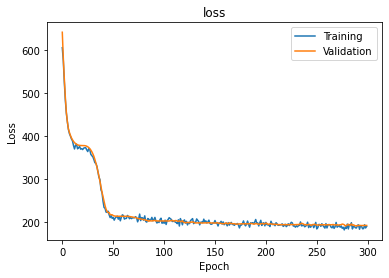

In [21]:
plt.plot(history['train_loss'])
plt.plot(history['val_loss'])
plt.title('loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc=0)
plt.savefig(summit_name+'_'+str(tl))

In [22]:
target_dataset = TensorDataset(torch.FloatTensor(target_x))
target_data_loader = DataLoader(target_dataset, batch_size=1, shuffle=False)
predicted_target = []

In [23]:
with torch.no_grad():
        for X in tqdm(target_data_loader):
            pred = model(X[0])
            predicted_target.append(pred.item())

  0%|          | 0/1108 [00:00<?, ?it/s]

In [24]:
summit = pd.DataFrame(predicted_target, columns=['target'])
summit.index.name = 'id'
summit['target'] = summit['target'].astype('int')

In [25]:
summit

,target
id,
0,664
1,889
2,917
3,1138
4,1470
...,...
1103,62
1104,36
1105,79


In [26]:
summit.to_csv(f'{summit_name}_{tl}.csv')